In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad

from scroutines import powerplots

In [2]:
outdir = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results_merfish/plots_240227"
outdatadir = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results_merfish"
!mkdir -p $outdir

In [3]:
f1 = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/merfish_20231114/region_0/cell_by_gene.csv'
f2 = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/merfish_20231114/region_0/cell_metadata.csv'
output = outdatadir + '/samp231114_reg0_240227.h5ad'

df1 = pd.read_csv(f1)
df2 = pd.read_csv(f2)

df1.shape, df2.shape

((115410, 551), (115410, 29))

In [4]:
genes = df1.iloc[:,1:-50].columns
blnks = df1.iloc[:, -50:].columns
df = df2.join(df1)
assert np.all(df['cell'] == df['EntityID'])
len(genes), len(blnks)

(500, 50)

<Axes: xlabel='volume', ylabel='Count'>

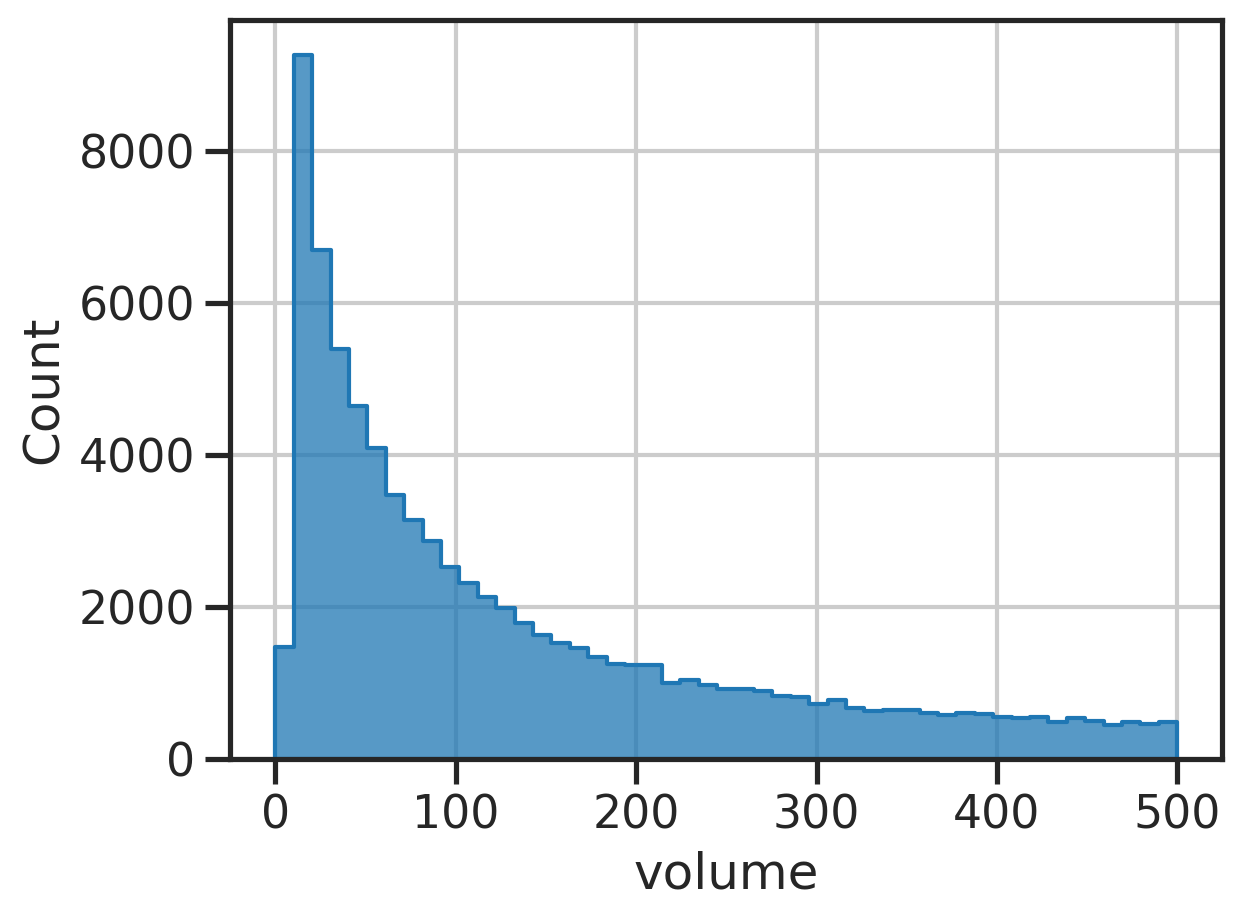

In [5]:
# sns.histplot(df2['volume'], cumulative=True, element='step')
sns.histplot(df2['volume'], element='step', bins=np.linspace(0,500,50))

In [6]:
# sns.histplot(df1[blnks].sum(axis=1), cumulative=True, element='step')

<Axes: xlabel='gncov', ylabel='Count'>

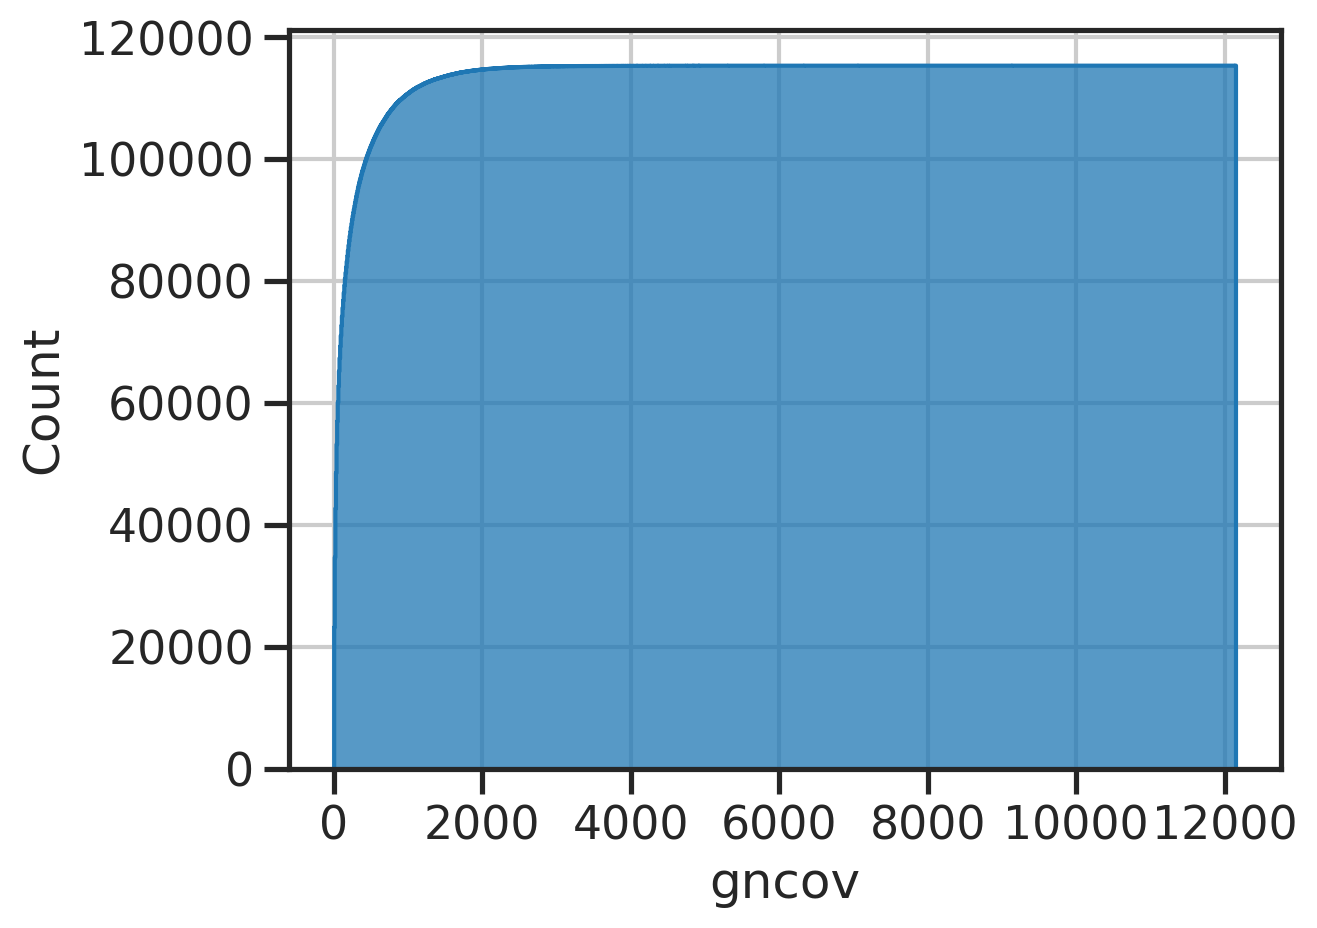

In [7]:
df['fpcov'] = df[blnks].sum(axis=1)
df['gncov'] = df[genes].sum(axis=1)
sns.histplot(df['gncov'], cumulative=True, element='step')

In [8]:
print(df.shape)
cond = np.all([
    df['volume'] < 5000, 
    df['volume'] > 10, 
    df['fpcov'] < 5,
    df['gncov'] > 10,
], axis=0)

df = df[cond] 
print(df.shape)

(115410, 582)
(76262, 582)


In [9]:
# functions (the teacher wrote for you to use later)
def rot2d(x, y, theta, unit='degree'):
    """ rotate data points defined by `x` and `y` by `theta` degree
    """
    a = np.vstack([x,y]).T
    if unit == 'degree':
        theta = theta*np.pi/180 # convert to radian

    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    ar = a.dot(R.T)
    return ar[:,0], ar[:,1]

def st_scatter(x, y, gexp=None, vmax_p=98, title='', s=1, cbar_label='', output='', cmap='rocket_r', axis_off=True):
    """customized scatter plot -- yesterday's progress
    """
  
    fig, ax = plt.subplots(figsize=(10,8))
    if gexp is not None:
        vmax = np.percentile(gexp, vmax_p)
        g = ax.scatter(x, y, c=gexp, s=s, edgecolor='none', vmax=vmax, cmap=cmap, rasterized=True)
        fig.colorbar(g, label=cbar_label, shrink=0.3)
    else:
        g = ax.scatter(x, y, s=s, edgecolor='none', cmap=cmap, rasterized=True)
  
    if axis_off:
        ax.axis('off')
    ax.set_title(title)
    ax.set_aspect('equal')
  
    if output:
        powerplots.savefig_autodate(fig, output)
        
    return 

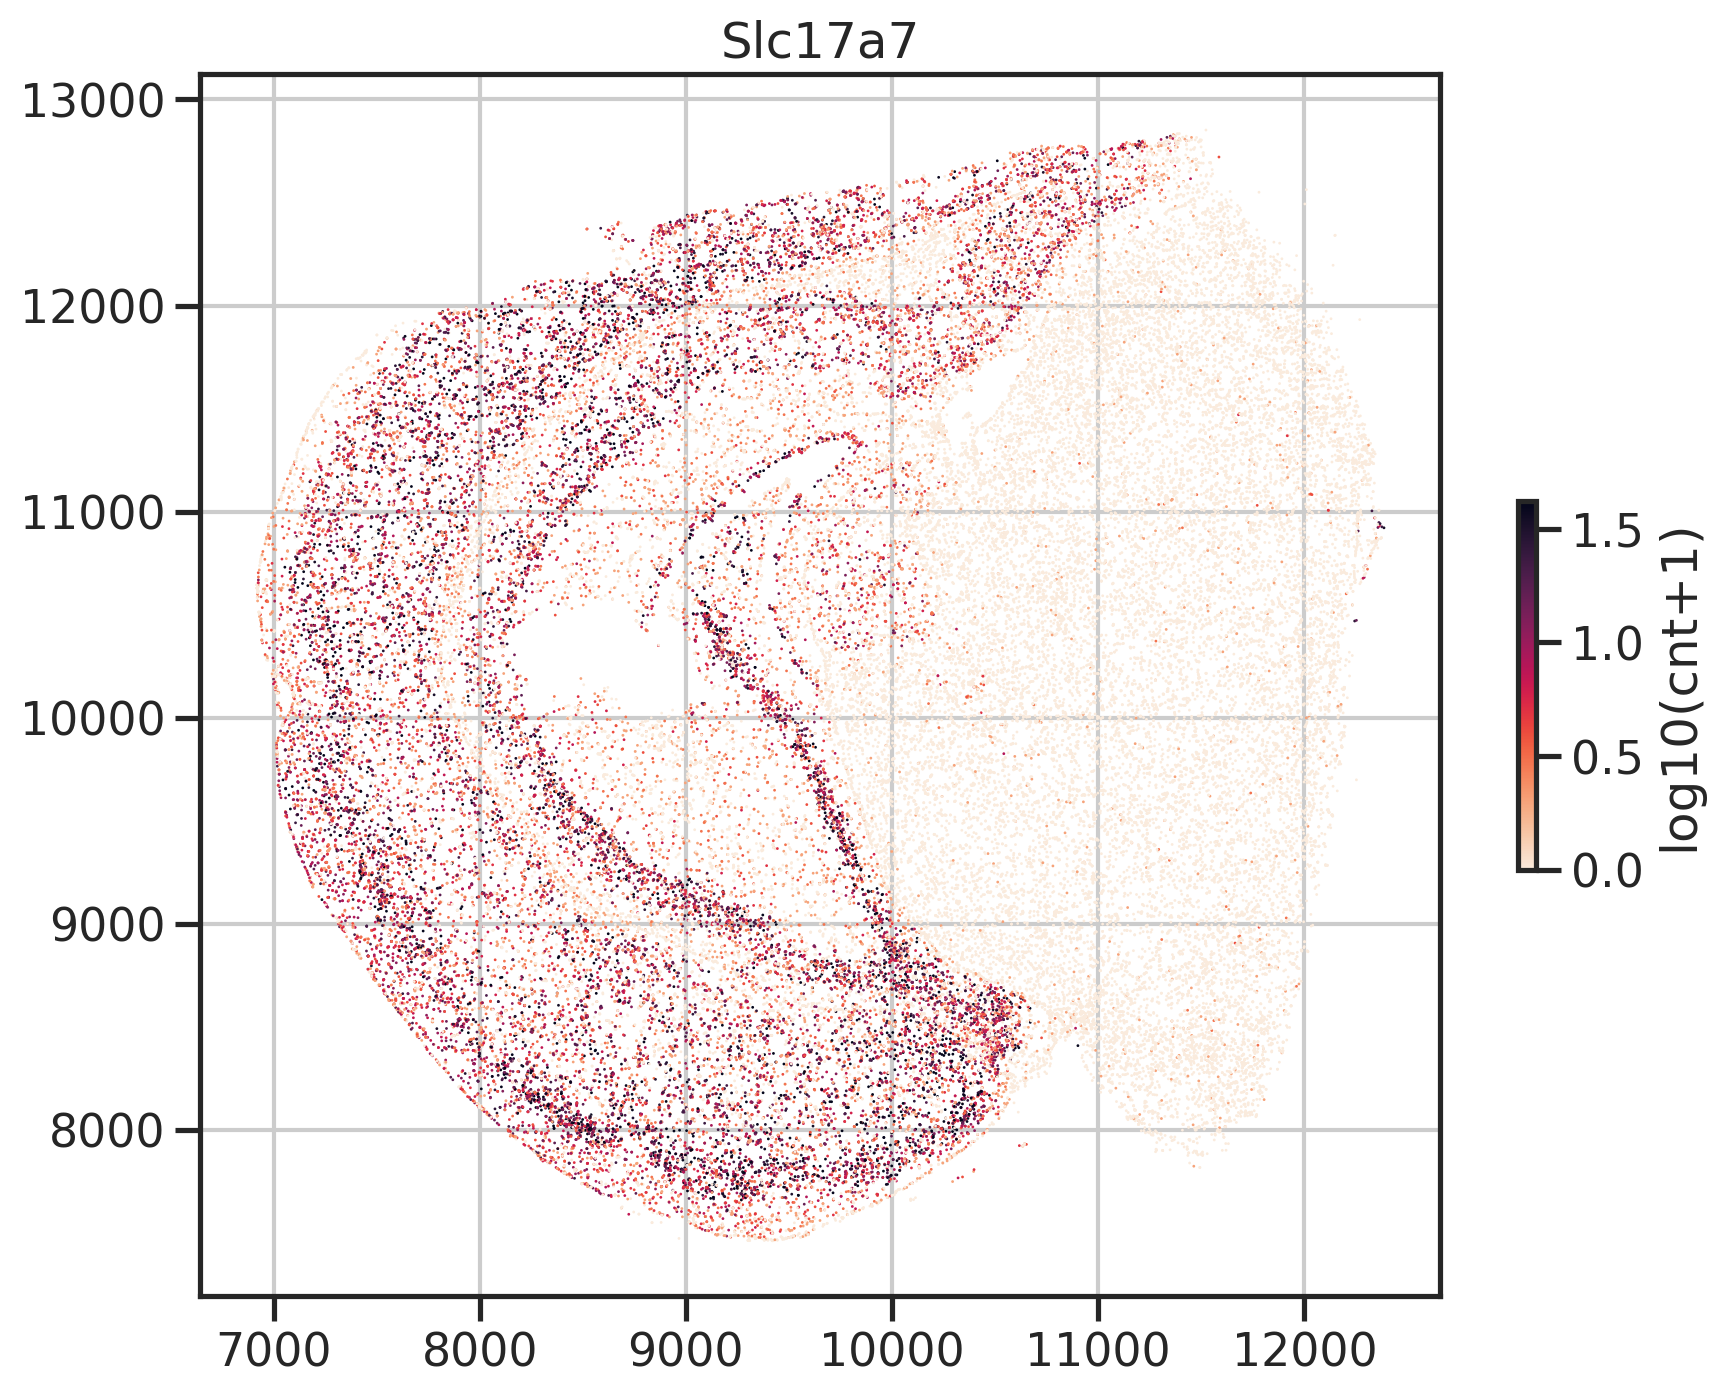

In [10]:
# calibrate coordinates

x = df['center_x']
y = df['center_y']
xr, yr = rot2d(x, y, 20)
df['x'] = xr
df['y'] = yr

gn = 'Slc17a7'
g = np.log10(1+df[gn])
st_scatter(xr, yr, gexp=g, title=gn, cbar_label='log10(cnt+1)', axis_off=False)

In [11]:
# focus on Visual cortex
cond_region = df['y'] > 10000
dfsub = df[cond_region]

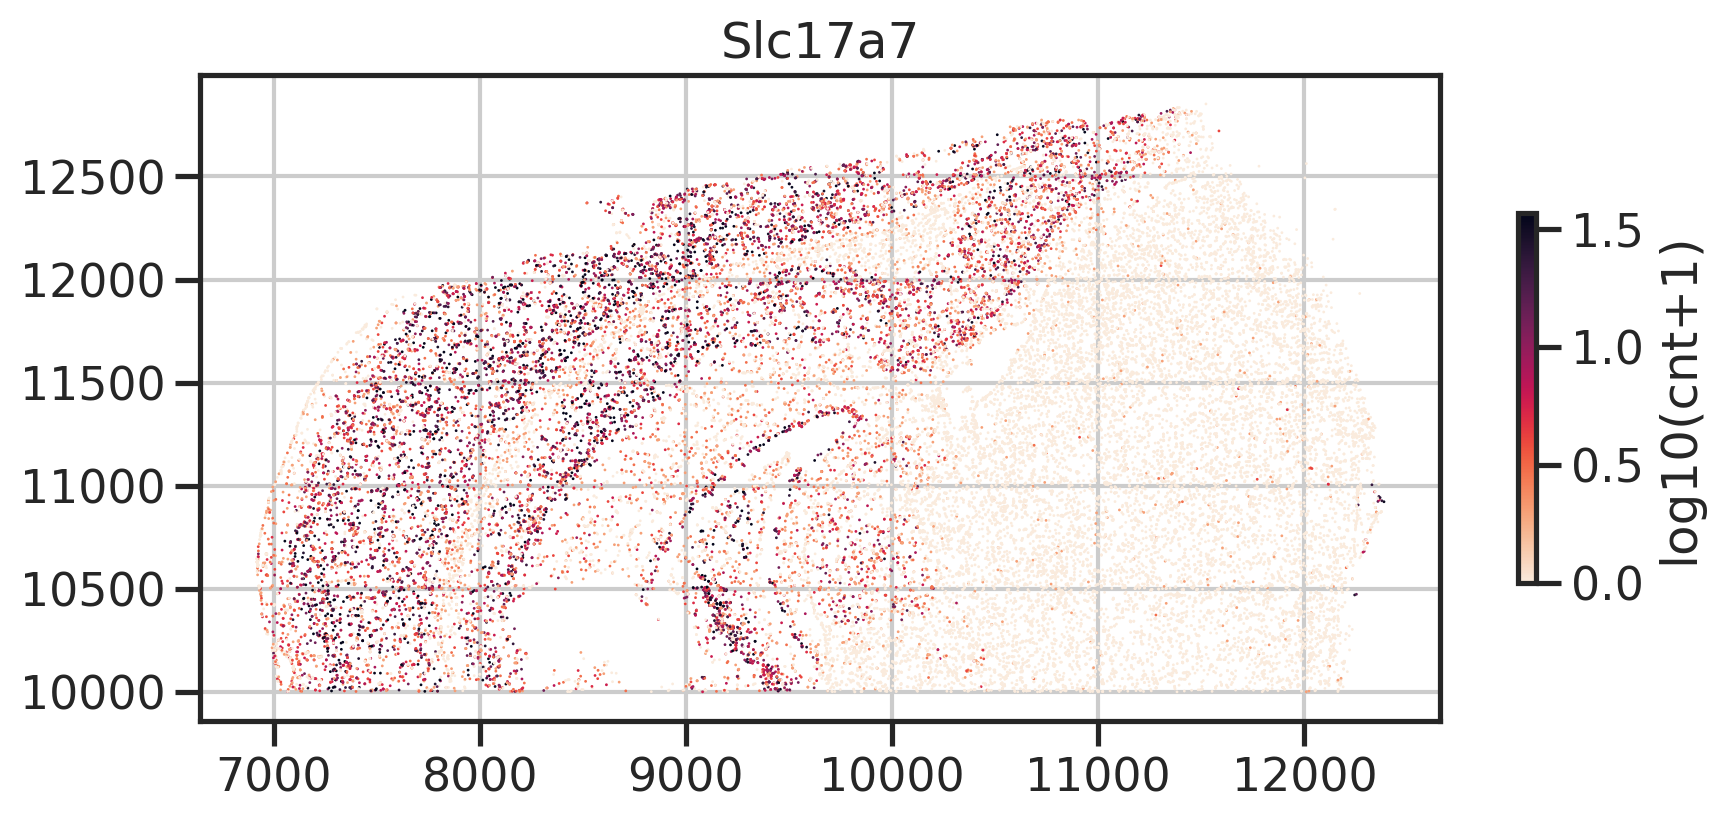

In [12]:
gn = 'Slc17a7'
g = np.log10(1+dfsub[gn])
xr = dfsub['x']
yr = dfsub['y']
st_scatter(xr, yr, gexp=g, title=gn, cbar_label='log10(cnt+1)', axis_off=False)

In [13]:
df2.columns

Index(['EntityID', 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y',
       'max_x', 'max_y', 'anisotropy', 'transcript_count',
       'perimeter_area_ratio', 'solidity', 'DreO_raw', 'DreO_high_pass',
       'Cre_raw', 'Cre_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'FlpO_raw',
       'FlpO_high_pass', 'Pvalb_raw', 'Pvalb_high_pass', 'Sst_raw',
       'Sst_high_pass', 'Fth1_raw', 'Fth1_high_pass', 'PolyT_raw',
       'PolyT_high_pass'],
      dtype='object')

In [14]:
metacols = np.hstack(['x', 'y', 'gncov', 'fpcov', df2.columns])
adata = ad.AnnData(X=dfsub[genes].values, 
                   obs=dfsub[metacols], 
                   var=pd.DataFrame(index=genes), 
                   obsm=dict(blanks=dfsub[blnks].values),
                  )

/u/home/f/f7xiesnm/.conda/envs/napari/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [15]:
output

'/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results_merfish/samp231114_reg0_240227.h5ad'

In [16]:
adata.write(output)

In [17]:
# for gn in genes:
#     g = np.log10(1+df[gn])
#     output = outdir + f'/{gn}.pdf'
#     print(output)
#     st_scatter(xr, yr, gexp=g, title=gn, cbar_label='log10(cnt+1)', output=output)
#     plt.close()
#     # break

In [18]:
# !ls $outdatadir